$$\textrm{Joaquin Peñuela Parraz}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

In [1]:
import os, sys

def add_parent_lib_path(name="Semanas_07_08_09"):
    sys.path.append(os.path.join(sys.path[0].split(name)[0],name))
    
add_parent_lib_path()

In [2]:
Path_Leptoquarks_searches = os.path.dirname(os.path.dirname(os.path.realpath('XBG_Discriminator_Histograms.ipynb')))

In [3]:
from Uniandes_Framework.ml_tools import tools
from Uniandes_Framework.delphes_reader import root_analysis

import pandas as pd

from ROOT import TCanvas #Permite poner los histogramas
from ROOT import THStack #Permite graficar varios histogramas al mismo tiempo
from ROOT import TLegend #Permite poner legends cuando se sobrelapan histogramas
from ROOT import TLatex #Permite poner avisos en Latex en las graficas

Welcome to JupyROOT 6.22/06


In [4]:
channels = ["hadronic_dLQ", "hadronic_sLQ", "hadronic_non-resonant", "semileptonic_dLQ", "semileptonic_sLQ", "semileptonic_non-resonant"]
signals = ['LQ_LQ', 'Tau_LQ', 'Tau_Tau']
Masses = ['1250', '1500', '1750', '2000', '2250', '2500']
bkgs = ['ttbar', 'z_jets', 'w_jets', 'stop','ww', 'wz', 'zz']

In [5]:
try: os.mkdir('Histograms')
except: pass

for channel in channels:
    try: os.mkdir(f'Histograms/{channel}')
    except: pass    

    bkg_dict = {}
    for bkg in bkgs: bkg_dict[bkg] = os.path.join(os.sep,"disco4","pheno_csv_files","Leptoquarks_Searches",bkg,f"{bkg}_{channel}.csv")
    
    most_important_features = []
    with open(os.path.join(os.getcwd(), 'XGB_models', channel, f'Most_Important_Features.txt'), "r") as f:
        for line in f: most_important_features.append(line.strip())
    f.close()
    
    for Mass in Masses:
        try: os.mkdir(f'Histograms/{channel}/M{Mass}')
        except: pass

        signal_dict = {}
        for signal in signals: signal_dict[f"{signal}_{Mass}"] = os.path.join(os.sep,"disco4","pheno_csv_files","Leptoquarks_Searches",f"{signal}_{Mass}",f"{signal}_{Mass}_{channel}.csv")

        path_model_mass =  os.path.join(os.getcwd(), 'XGB_models', channel, f'M{Mass}_XGB.joblib')
        bkg_and_signal_dict = bkg_dict | signal_dict
        path_folder_mass = os.path.join(os.getcwd(), 'Histograms', channel,f'M{Mass}')
        
        with root_analysis.Quiet(): tools.hist_discriminator(path_model= path_model_mass, csv_dict = bkg_and_signal_dict, path_to_save= path_folder_mass, best_features= most_important_features)

In [7]:
def Read_Cutflows_N_Events(channel, signal, Luminosity = 137*1000):

    cutflows_path = os.path.join(Path_Leptoquarks_searches, '03_delphes_preselection/Cutflows', f'{channel}.csv')
    cutflows_file = pd.read_csv(cutflows_path, index_col= 0)
    cutflows_file = cutflows_file.dropna()
    
    Efficience = cutflows_file[signal]['DeltaR > 0.3']/cutflows_file[signal]['All']
    XS = cutflows_file[signal]['XS']
    return Efficience*XS*Luminosity

In [38]:
histograms = {}

In [39]:
for channel in channels:    
    histograms[channel] = {}
    for Mass in Masses:
                
        path_root_file = os.path.join(os.getcwd(), 'Histograms', channel,f'M{Mass}', f'Histograms_M{Mass}_XGB.root')       
        histograms[channel][f'M{Mass}'] = root_analysis.Read_ROOT_File(path_root_file, expected_keys = [f"{signal}_{Mass}" for signal in signals] + bkgs)
        
        for signal_key in histograms[channel][f'M{Mass}'].keys():
            histo = histograms[channel][f'M{Mass}'][signal_key]
            N_events = Read_Cutflows_N_Events(channel, signal_key)
            histo.Scale(N_events/histo.Integral())
            
        N_events = Read_Cutflows_N_Events(channel, 'w_jets')
        h_w_jets = histograms[channel][f'M{Mass}']['z_jets'].Clone('')
        h_w_jets.SetDirectory(0)
        h_w_jets.Scale(N_events/h_w_jets.Integral())
        h_w_jets.SetNameTitle('w_jets', 'w_jets')
        
        histograms[channel][f'M{Mass}']['w_jets'] = h_w_jets

In [40]:
canvas = TCanvas("Canvas", " ", 600, 400)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


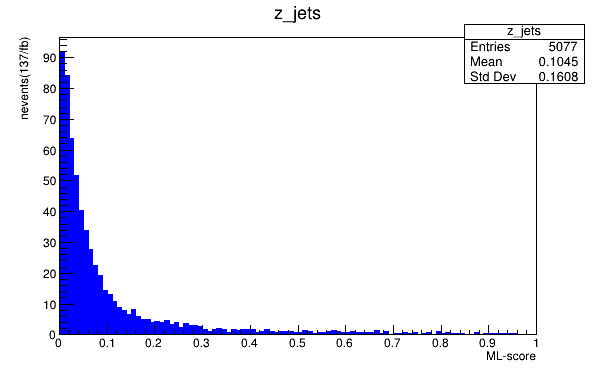

In [41]:
histograms['hadronic_dLQ']['M1250']['z_jets'].Draw('hist')
canvas.Draw()

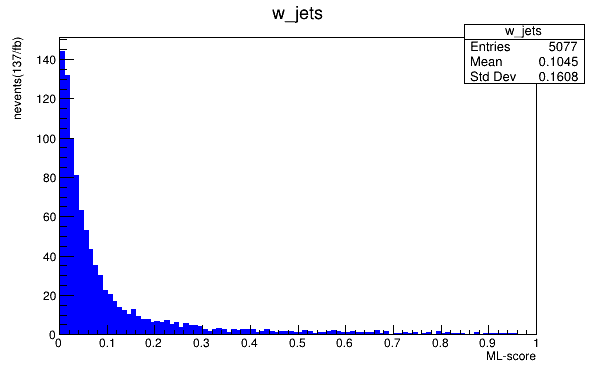

In [42]:
histograms['hadronic_dLQ']['M1250']['w_jets'].Draw('hist')
canvas.Draw()

In [43]:
histograms['hadronic_dLQ']['M1250'].keys()

dict_keys(['LQ_LQ_1250', 'Tau_LQ_1250', 'Tau_Tau_1250', 'ttbar', 'z_jets', 'stop', 'ww', 'wz', 'zz', 'w_jets'])

In [ ]:
# #2022:

# def Overlap_Histos(histogramas_signal, histogramas_bkg, process, channel,
#                    signals, bkgs, Titulo, M, ignorar = '', alpha_bkg = 0.05, alpha_signal = 0.05, 
#                    Stack = False, Log_Y = False, Log_X = True,Grid = False):
    
#     #Si Stack es False -> Se normaliza por unidad de area
#     #Si Stack es True -> Se normaliza según el número de eventos
    
#     canvas = TCanvas(Titulo, " ", 800, 600)
    
#     #legend = TLegend(0.9,.4,1,.89) #Afuera de la grafica
#     legend = TLegend(0.48,.75,0.87,.89)
#     legend.SetNColumns(4) 
#     legend.SetHeader('M_{U}' + f'= {int(M)/1000} TeV' + ', g_{U} = 1.8' + ', #beta_{R}^{b #tau} = -1',"C")
#     legend.SetLineWidth(1)
    
#     #legend.SetFillStyle(0) #Así la ventana con los legends es transparente

#     Histos = THStack('hist', Titulo)
        
#     for i in range(len(bkgs.keys())):
#             combinacion_bkg = list(bkgs.keys())[i]
#             bkg_list = bkgs[combinacion_bkg]
            
#             histo_list = []
#             for bkg in bkg_list:
#                 if (bkg != ignorar):
#                     if (histogramas_bkg[M][process][channel][bkg] != {}):
#                         h = histogramas_bkg[M][process][channel][bkg]
#                         h.Scale(N_events(process, channel, bkg)/h.Integral())
#                         histo_list.append(h)
                
#             histo_Nevents = sum_histos(histo_list)
            
#             histo_normalizado = sum_histos(histo_list)
#             histo_normalizado.Scale(1.0/histo_normalizado.Integral())
            
#             if (Stack): histo = histo_Nevents
#             else: histo = histo_normalizado
            
#             color = len(signals.keys()) + i + 1
#             if color == 7: color = 3
                
#             histo.SetLineColor(color)
#             histo.SetFillColorAlpha(color, alpha_bkg)
#             histo.SetLineWidth(2)
#             histo.SetDirectory(0)     
            
#             Histos.Add(histo)
#             legend.AddEntry(histo,combinacion_bkg)
            
#     for j in range(len(signals.keys())):
#             combinacion_signal = list(signals.keys())[j]
#             signal_list = signals[combinacion_signal]
            
#             histo_list = []
#             for signal in signal_list:
#                 if (signal != ignorar):
#                     if (histogramas_signal[M][process][channel][signal] != {}):
#                         h = histogramas_signal[M][process][channel][signal]
#                         h.Scale(N_events(process, channel, f'{signal}_{M}')/h.Integral())
#                         histo_list.append(h)
                
#             histo_Nevents = sum_histos(histo_list)
            
#             histo_normalizado = sum_histos(histo_list)
#             histo_normalizado.Scale(1.0/histo_normalizado.Integral())
            
#             if (Stack): histo = histo_Nevents
#             else: histo = histo_normalizado
            
#             color = j + 1
#             if color == 3: color = 7
            
#             histo.SetLineColor(color)
#             histo.SetFillColorAlpha(color, alpha_signal)
#             histo.SetLineStyle(2)
#             histo.SetLineWidth(2)
#             histo.SetDirectory(0)     
            
#             Histos.Add(histo)
#             legend.AddEntry(histo,combinacion_signal)
            
#     if Log_Y: canvas.SetLogy()
#     if Log_X: canvas.SetLogx()
#     if Grid: canvas.SetGrid()
    
#     eje_x = 'XGB-Output'
    
#     if Stack:
#         Histos.Draw("hist")
#         Histos.SetTitle(f'{Titulo}; {eje_x}; Events')  
        
#     else: 
#         Histos.Draw("histnostack")
#         Histos.SetTitle(f'{Titulo}; {eje_x}; A.U')  
    
#     latex = TLatex()
#     latex.SetNDC()
#     latex.SetTextSize(0.04)
#     latex.DrawLatex(0.76,0.91,'#sqrt{s} = 13 TeV')
#     #latex.DrawLatex(0.61,0.91,'#sqrt{s} = 13 TeV, L = 137 fb^{-1}')

    
#     canvas.Draw()
#     legend.Draw('same')
    
#     #Histos.GetXaxis().SetLimits(0.0, float(M)*3)  
    
#     return Histos, canvas, legend